In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import logging

In [9]:
n = 10 # 10个臂
bandit_p = np.random.rand(n)

def gen_data(i):
    assert i < n
    if np.random.rand() < bandit_p[i]:
        return 1.0  # reward
    return 0.0 # no reward

In [13]:
# 随机选择一个

def random_select(ctx):
    return np.random.randint(ctx['n'])


def determine_select(ctx):
    if ctx['step'] < n:
        return ctx['step']
    return np.argmax(ctx['cum_reward_action'] / (ctx['cum_action']))

# epsilon 贪心

def epsilon_greedy(ctx):
    epsilon = 1 / (1 + np.sqrt(ctx['step']))
    if np.random.rand() < epsilon: # random
        return random_select(ctx)
    else:
        return determine_select(ctx)


# naive

def naive_select(ctx):
    if ctx['step'] < 500:
        return random_select(ctx)
    else:
        return determine_select(ctx)

# softmax
def softmax_select(ctx, n0 = 0.1):
    if ctx['step'] < n:
        return ctx['step']
    avg_reward = ctx['cum_reward_action'] / (ctx['cum_action'])
    p = np.exp(avg_reward / n0 )
    p = p / np.sum(p)
    #print ctx['step'], p
    #if ctx['step'] % 100 == 0:
    #    print (str(p))
    return np.random.multinomial(1, p)[0]

    ###
def thompson_select(ctx):
    win = ctx['cum_reward_action']
    loss = ctx['cum_action'] - win
    p = np.zeros(n)
    for i in range(n):
        # 期望概率 p_i = (1 + win[i]) / (1 + trials[i]), 现在不是用期望的概率,而是引入一定的随机性,随机从p_i服从的beta分布中采样一个结果
        p[i] = np.random.beta(1 + win[i], 1 + loss[i])
    return np.argmax(p)

def ucb_select(ctx):
    if ctx['step'] < n:
        return ctx['step']
    cum_n = ctx['step'] + 1.0
    up_bound = ctx['cum_reward_action'] / (ctx['cum_action']) + np.sqrt(2.0 * np.log(cum_n) / ctx['cum_action'])
    return np.argmax(up_bound)

In [5]:
@jit
def simulation(select_action, n_ = 3000):
    t = []
    reward = []
    cum_reward_per = 0.0
    cum_reward_action = np.zeros(n)
    cum_action = np.zeros(n)
    for i in range(n_):
        t.append(i)
        ctx = {'n' : n, 'cum_reward_action' : cum_reward_action, 'cum_action' : cum_action, 'step': i}
        action = select_action(ctx)
        cum_action[action] += 1
        r = gen_data(action)
        action_n = cum_action[action]
        cum_reward_action[action] += r
        cum_reward_per += r
        reward.append(cum_reward_per)
    return np.array(t), np.array(reward)

@jit
def run(select_action, rnd_ = 100, n_ = 3000):
    t = []
    avg_reward = 0
    for i in range(rnd_):
        t, reward = simulation(select_action, n_)
        avg_reward = avg_reward * i / (i + 1) + reward / (i+1)

        logging.info("simulate %d round." % (i))
    return t, np.max(bandit_p) - avg_reward /(1 + np.arange(n_))

/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide


Text(0,0.5,u'regret')

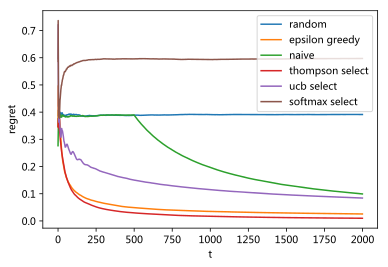

In [15]:
n_ = 2000
t, r = run(random_select, n_ = n_)
plt.plot(t, r)

t, r = run(epsilon_greedy, n_ = n_)
plt.plot(t, r)

t, r = run(naive_select, n_ = n_)
plt.plot(t, r)

t, r = run(thompson_select, n_ = n_)
plt.plot(t, r)

t, r = run(ucb_select, n_ = n_)
plt.plot(t, r)

t, r = run(softmax_select, n_ = n_)
plt.plot(t, r)


plt.legend(['random', 'epsilon greedy', 'naive', 'thompson select', 'ucb select', 'softmax select'])
plt.xlabel('t')
plt.ylabel('regret')

In [30]:
np.argmax(bandit_p) - np.mean(bandit_p)

3.5700523317477573